In [1]:
# Dependencies
import casadi as ca
import numpy as np
import os

## Prerequsites
 * Install VS Code
 * Open Jupyter notebook example

## Parameter estimation for an event system in CasADi

The following notebook demonstrates how to use CasADi to solve a system identification task using a first principles model with event dynamics from Modelica.
The example leverages the newly added functionality in CasADi to perform analytic and automatic sensitivity analysis for event systems, presented at the 2024 American Modelica Conference.
The example also uses a legacy symbolic Modelica-to-CasADi toolchain, i.e. the Modelica *equations* are converted into CasADi expressions rather than called as an external function. The intention is to replace this toolchain with a new toolchain based on the emerging Base Modelica standard.


## A hybrid system in Modelica
In the following, we will work with a simple event system corresponding to a spring that breaks when extended far enough. Importantly, it contains an event, given by a Modelica *when* equation. When the event is triggered, a boolean variable representing whether the spring is broken is updated.

In [2]:
# Display content of Modelica sources
with open('BreakingSpring.mo', 'r') as f:
    for line in f: print(line, end = '')

model BreakingSpring
    input Real m(start = 1) "PARAMETER:Mass";
    output Real v(start = -5, fixed = true) "velocity";
    output Real x(start = -1, fixed = true) "displacement";
    input Real k(start = 2) "PARAMETER:spring constant";
    input Real c(start = 0.1) "PARAMETER:damping constant";
    input Real d(start = 0) "disturbance";
    Real f "spring force";
    Boolean b "Is the spring broken?";
initial equation
  b = false;
equation
    der(x) = v;
    f = if not b then -k * x + d else 0;
    m * der(v) + c * v = f;
    when x>2 then
      b = true;
    end when;
end BreakingSpring;

## Import model into CasADi
We will use OpenModelica to compile this model into a so-called FMUX, a legacy format originally developed for the interoperability between CasADi and JModelica.org. While support for this format it limited, it is sufficient to use for the relatively simple model considered here. It is out intention to replace this step with a more feature-complete and better maintained symbolic toolchain, based on the emerging Base Modelica standard. This alternative approach should be compatible with multiple Modelica compilers, not only Open Modelica. 

In the following, we will assume that the FMUX file has been precompiled and unpacked to the current working directly.

This model is used to create a CasADi DaeBuilder class instance

In [3]:
# Load the OpenModelica XML file (warnings reflect the unstable nature of the currently used symbolic toolchain)
dae = ca.DaeBuilder('BreakingSpring', os.path.join(os.path.abspath(""), 'BreakingSpringXML'))

CasADi - 2024-11-18 10:46:57 WARNING("Duplicate variable 'v' ignored") [.../casadi/core/dae_builder_internal.cpp:2726]
CasADi - 2024-11-18 10:46:57 WARNING("Duplicate variable 'x' ignored") [.../casadi/core/dae_builder_internal.cpp:2726]
CasADi - 2024-11-18 10:46:57 WARNING("initeq_2 defines a tunable parameter, ignored") [.../casadi/core/dae_builder_internal.cpp:3155]
CasADi - 2024-11-18 10:46:57 WARNING("initeq_4 defines a tunable parameter, ignored") [.../casadi/core/dae_builder_internal.cpp:3155]
CasADi - 2024-11-18 10:46:57 WARNING("initeq_5 defines a tunable parameter, ignored") [.../casadi/core/dae_builder_internal.cpp:3155]
CasADi - 2024-11-18 10:46:57 WARNING("initeq_7 duplicate of previous equation v == -5, ignored") [.../casadi/core/dae_builder_internal.cpp:3162]
CasADi - 2024-11-18 10:46:57 WARNING("initeq_8 is empty, ignored.") [.../casadi/core/dae_builder_internal.cpp:3138]
CasADi - 2024-11-18 10:46:57 WARNING("initeq_9 duplicate of previous equation x == -1, ignored") [.

In [4]:
dae.disp(True)

nx = 3, nz = 0, nq = 0, ny = 0, np = 3, nc = 0, nd = 0, nw = 1, nu = 1
Variables
  p = [c, k, m]
  x = [b, v, x]
  w = [f]
  u = [d]
Dependent equations
  f == ((!b)?(d-(k*x)):0)
Differential equations
  \dot{b} == 0
  \dot{v} == der(v) := ((f-(c*v))/m)
  \dot{x} == der(x) := v
Initial equations
  v := -5
  x := -1
  d := 0
  b := 0
When statements
  when (x-2) > 0 : b := 1


In [5]:
# The model contains dependent variables that can be explicitly eliminated. Let's perform this elimination and look at the corresponding equations
dae.eliminate_d()
dae.eliminate_w()
dae.disp(True)

nx = 3, nz = 0, nq = 0, ny = 0, np = 3, nc = 0, nd = 0, nw = 0, nu = 1
Variables
  p = [c, k, m]
  x = [b, v, x]
  u = [d]
Differential equations
  \dot{b} == 0
  \dot{v} == der(v) := ((((!b)?(d-(k*x)):0)-(c*v))/m)
  \dot{x} == der(x) := v
Initial equations
  v := -5
  x := -1
  d := 0
  b := 0
When statements
  when (x-2) > 0 : b := 1


The equation above represents a symbolic reprsentation of the model in a *standard* form, a form that can be used for simulation and optimization in CasADi.

In [6]:
# From the DaeBuilder instance we can generate a DAE right-hand-side function in CasADi format
# Note that this function includes a zero-crossing function as its last argument
daefun = dae.create('daefun')
daefun.disp(True)

daefun:(t[0],x[3],z[0],p[3],u)->(ode[3],alg[0],quad[0],zero) MXFunction
Algorithm:
@0 = 0
output[0][0] = @0
@0 = input[1][0]
@0 = (!@0)
@1 = input[4][0]
@2 = input[3][1]
@3 = input[1][2]
@2 = (@2*@3)
@1 = (@1-@2)
@0 = (@0?@1:0)
@1 = input[3][0]
@2 = input[1][1]
@1 = (@1*@2)
@0 = (@0-@1)
@1 = input[3][2]
@0 = (@0/@1)
output[0][1] = @0
output[0][2] = @2
@2 = 2
@3 = (@3-@2)
output[3][0] = @3

In [9]:
# Note that we could also generate a function in some other format, e.g. simply dot(x) = odefun(t, x)
odefun = dae.create('odefun', ['t', 'x'], ['ode'])
odefun

Function(odefun:(t[0],x[3])->(ode[3]) MXFunction)

In [42]:
daefun.save('test.casadi')

Events in CasADi consists of two parts:
 * A zero-crossing function indicating when an event is triggered. It is represented by the (recently added) `zero` argument to the DAE function above
 * An event transition function describing how the state vector gets reset at events

The latter function can be obtained fron CasADi as follows:

In [11]:
# Construct an event transition function
eventfun = dae.event_transition("eventfun")
eventfun

Function(eventfun:(index[],t[0],x[3],z[0],p[3],u)->(post_x[3],post_z[0]) MXFunction)

In [12]:
# The event function above will handle all event via a switch, if there are multiple zero crossing functions
# You can specify the event with the "index" argument (first input)
# You can also create a event transition function only for a specific event, without the index argument
eventfun_0 = dae.event_transition("eventfun_0", 0)
eventfun_0

Function(eventfun_0:(t[0],x[3],z[0],p[3],u)->(post_x[3],post_z[0]) MXFunction)

Let us evaluate the event transition function, we will set the free parameters to their default values:

In [18]:
# Get parameter values
p = dae.p()
p0 = [dae.start(n) for n in p]
print(f'{p} := {p0}')

['c', 'k', 'm'] := [0.1, 2.0, 1.0]


In [19]:
# In our example, the function will be an identify mapping for all states except "is_broken", which always becomes 1
eventfun(x = [0, 20, 30], p = p0)

{'post_x': DM([1, 20, 30]), 'post_z': DM(0x1)}

`post_x` here refers to the new state `x`. The second output (`post_z`) refers to *algebraic* variables, which are absent in this example.

In [20]:
# Create an integrator in CasADi for hybrid simulation
tgrid = np.linspace(0, 4, 101)
simopts = dict(verbose = True,
               event_transition = eventfun,
               event_tol = 1e-12)
sim = ca.integrator('sim', 'cvodes', daefun, 0, tgrid, simopts)
sim

CasADi - 2024-11-18 10:54:13 MESSAGE("sim::init") [.../casadi/core/function_internal.cpp:547]
CasADi - 2024-11-18 10:54:13 MESSAGE("sim::create_function daeF:[t, x, z, p, u]->[ode, alg]") [.../casadi/core/oracle_function.cpp:219]
CasADi - 2024-11-18 10:54:13 MESSAGE("sim::create_function jacF:[t, x, z, p, u]->[jac:ode:x, jac:alg:x, jac:ode:z, jac:alg:z]") [.../casadi/core/oracle_function.cpp:219]


CasADi - 2024-11-18 10:54:13 WARNING("Event support is experimental") [.../casadi/core/integrator.cpp:761]


Function(sim:(x0[3],z0[0],p[3],u[1x101],adj_xf[],adj_zf[],adj_qf[])->(xf[3x101],zf[0x101],qf[0x101],adj_x0[],adj_z0[],adj_p[],adj_u[]) CvodesInterface)

In [21]:
# Select some disturbances
u_traj = np.zeros(tgrid.shape)
u_traj[20:30] = -5
u_traj[40:50] = 15

In [22]:
# Initial state
x = dae.x()
x0 = dae.start(x)
print(f'x = {x}, x0 = {x0}')

x = ['b', 'v', 'x'], x0 = [0.0, -5.0, -1.0]


In [23]:
# Test evaluating the DAE function at the initial point
rr = daefun(x=x0, u=0, p = p0)
print(rr)


{'alg': DM(0x1), 'ode': DM([0, 2.5, -5]), 'quad': DM(0x1), 'zero': DM(-3)}


## Hybrid simulation and sensitivity analysis

In [24]:
# Simulate the system
res = sim(x0 = x0, p = p0, u = u_traj)

CasADi - 2024-11-18 10:54:16 MESSAGE("sim::reset") [.../casadi/interfaces/sundials/cvodes_interface.cpp:232]
CasADi - 2024-11-18 10:54:16 MESSAGE("Interval 0: Integrating forward from 0 to 0, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:54:16 MESSAGE("Interval 1: Integrating forward from 0 to 0.04, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:54:16 MESSAGE("Interval 2: Integrating forward from 0.04 to 0.08, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:54:16 MESSAGE("Interval 3: Integrating forward from 0.08 to 0.12, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:54:16 MESSAGE("Interval 4: Integrating forward from 0.12 to 0.16, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:54:16 MESSAGE("Interval 5: Integrating forward from 0.16 to 0.2, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:54:16 MESSAGE("Interval 6:

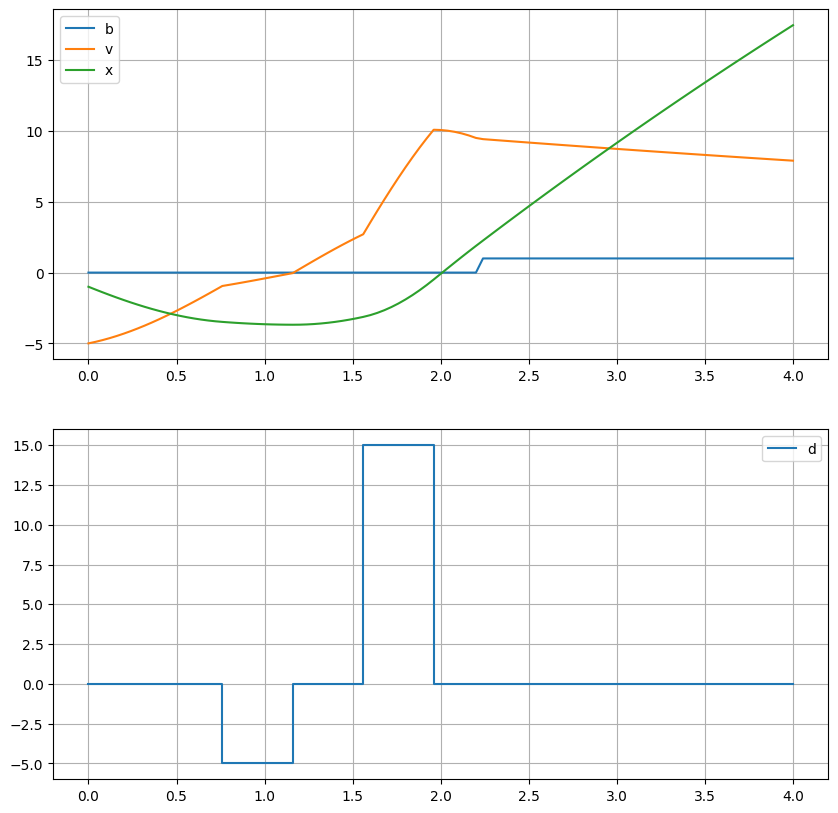

In [25]:
# Visualize the solution
import matplotlib.pyplot as plt
fig, [ax_x, ax_u] = plt.subplots(2, 1, figsize = [10, 10])

# States
ax_x.plot(tgrid, res['xf'].T, label = dae.x())
ax_x.legend()
ax_x.grid(True)
# Distrubances
ax_u.step(tgrid, u_traj, label = dae.u()[0])
ax_u.legend()
ax_u.grid(True)


In [26]:
# Nominal value for parameters, use for step size
p_nom = [dae.nominal(n) for n in dae.p()]
p_nom

[1.0, 1.0, 1.0]

In [27]:
# Forward sensitivities
nfwd = len(p0)

In [28]:
# Dimensionless step size
sigma = 1e-3

# Simulate unperturbed solution and with each input perturbed
pertres = [sim(x0 = x0, p = p0, u = u_traj)]
for i in range(nfwd):
    # Save unperturbed p0[i]
    p0_unpert = p0[i]
    # Perturb p0[i]
    p0[i] += sigma * p_nom[i]
    # Simulate perturbed
    pertres.append(sim(x0 = x0, p = p0, u = u_traj))
    # Restore p0[i]
    p0[i] = p0_unpert


CasADi - 2024-11-18 10:58:24 MESSAGE("sim::reset") [.../casadi/interfaces/sundials/cvodes_interface.cpp:232]
CasADi - 2024-11-18 10:58:24 MESSAGE("Interval 0: Integrating forward from 0 to 0, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:58:24 MESSAGE("Interval 1: Integrating forward from 0 to 0.04, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:58:24 MESSAGE("Interval 2: Integrating forward from 0.04 to 0.08, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:58:24 MESSAGE("Interval 3: Integrating forward from 0.08 to 0.12, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:58:24 MESSAGE("Interval 4: Integrating forward from 0.12 to 0.16, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:58:24 MESSAGE("Interval 5: Integrating forward from 0.16 to 0.2, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:58:24 MESSAGE("Interval 6:

In [29]:
# New integrator instance with forward sensitivities
simopts['nfwd'] = nfwd
simopts['verbose'] = True
simfun_fwd = ca.integrator('sim', 'cvodes', daefun, 0, tgrid, simopts)

CasADi - 2024-11-18 10:58:25 MESSAGE("sim::init") [.../casadi/core/function_internal.cpp:547]
CasADi - 2024-11-18 10:58:25 MESSAGE("sim::create_function daeF:[t, x, z, p, u]->[ode, alg]") [.../casadi/core/oracle_function.cpp:219]
CasADi - 2024-11-18 10:58:25 MESSAGE("sim::create_function jacF:[t, x, z, p, u]->[jac:ode:x, jac:alg:x, jac:ode:z, jac:alg:z]") [.../casadi/core/oracle_function.cpp:219]
CasADi - 2024-11-18 10:58:25 MESSAGE("sim::create_function jtimesF:[t, x, z, p, u, fwd:x, fwd:z]->[fwd:ode, fwd:alg]") [.../casadi/core/oracle_function.cpp:219]


CasADi - 2024-11-18 10:58:25 WARNING("Event support is experimental") [.../casadi/core/integrator.cpp:761]


In [30]:
u = dae.u()
x = dae.x()
p = dae.p()
N = len(tgrid)
print(f'x = {x}, p = {p}, u = {u}')

x = ['b', 'v', 'x'], p = ['c', 'k', 'm'], u = ['d']


In [31]:
# Forward sensitivities
fwd_x0 = ca.DM.zeros(len(x), nfwd)
fwd_p = ca.DM.zeros(len(p), nfwd)
fwd_u = ca.DM.zeros(len(u), nfwd * N)

# Seed the parameters
for d in range(nfwd):
    fwd_p[d, d] = 1

# Inputs to the augmented problem
aug_x0 = ca.horzcat(x0, fwd_x0)
aug_p = ca.horzcat(p0, fwd_p)
aug_u = ca.reshape(ca.vertcat(ca.reshape(u_traj, len(u), N), ca.reshape(fwd_u, len(u) * nfwd, N)), len(u), (nfwd + 1) * N)

# Simulated with sensitivities
fwdres = simfun_fwd(x0 = aug_x0, p = aug_p, u = aug_u)

CasADi - 2024-11-18 10:58:27 MESSAGE("sim::reset") [.../casadi/interfaces/sundials/cvodes_interface.cpp:232]
CasADi - 2024-11-18 10:58:27 MESSAGE("Interval 0: Integrating forward from 0 to 0, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:58:27 MESSAGE("Interval 1: Integrating forward from 0 to 0.04, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:58:27 MESSAGE("Interval 2: Integrating forward from 0.04 to 0.08, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:58:27 MESSAGE("Interval 3: Integrating forward from 0.08 to 0.12, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:58:27 MESSAGE("Interval 4: Integrating forward from 0.12 to 0.16, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:58:27 MESSAGE("Interval 5: Integrating forward from 0.16 to 0.2, t_stop = 0.76") [.../casadi/core/integrator.cpp:431]
CasADi - 2024-11-18 10:58:27 MESSAGE("Interval 6:

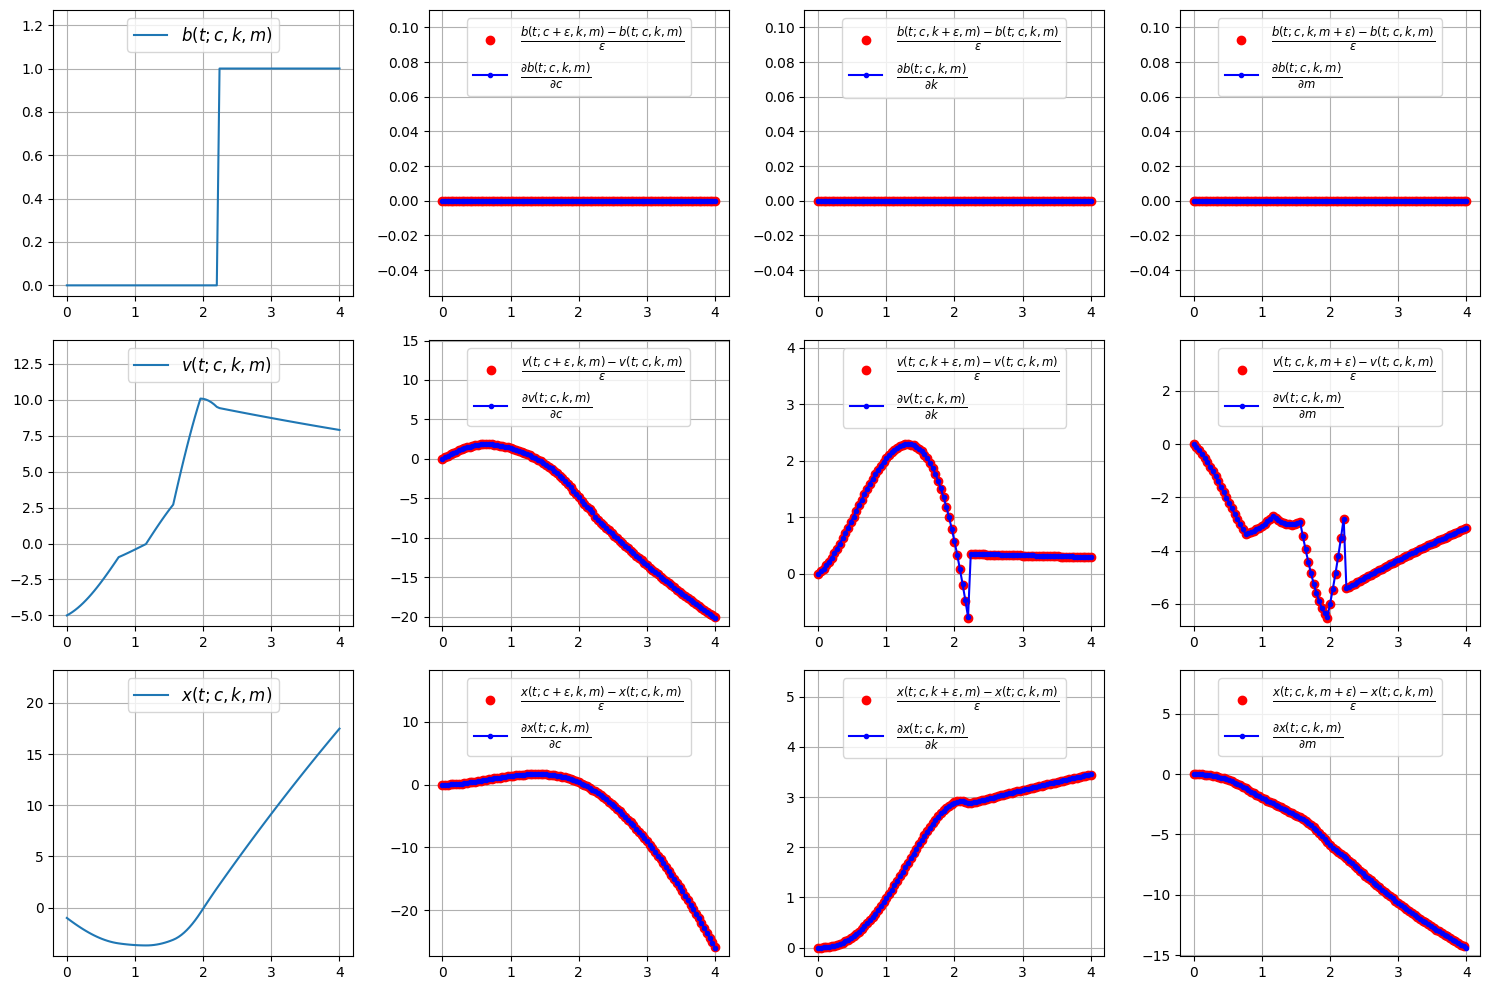

In [32]:
# Unperturbed arguments
sens_p = p
sens_arg = '(t;' + ','.join(sens_p) + ')'
# Visualize the solution
fig, ax = plt.subplots(nrows = len(x), ncols = nfwd + 1, figsize = (15,10))
for r in range(len(x)):
    for c in range(nfwd + 1):
        ax_rc = ax[r][c]
        # Also include finite difference perturbation
        if c == 0:
            # Plot unperturbed solution
            ax_rc.plot(tgrid, fwdres['xf'][r, 0::len(x)+1].T, label=f'${x[r]}{sens_arg}$')
            yaxis_label_margin = .2

            # for c1 in range(1, nfwd + 1):
            #      ax_rc.plot(tgrid, pertres[c1]['xf'][r, :].T, label = f'pert, {x[c1 - 1]}')

        else:
            # AD solution
            ad = fwdres['xf'][r, c::nfwd+1].T
            ad = ad.full()
            # FD solution
            fd = (pertres[c]['xf'][r, :].T - pertres[0]['xf'][r, :].T) / (sigma * p_nom[c - 1])
            fd = fd.full()
            # Need to cap large and small entries: Start with AD solution
            min_fd = ad.min()
            max_fd = ad.max()
            # Ensure that the median of the FD solution is well within the figure
            median_fd = np.median(fd)
            max_fd = max(max_fd, min_fd + 2 * (median_fd - min_fd))
            min_fd = min(min_fd, max_fd - 2 * (max_fd - median_fd))
            # Cap entries by setting the corresponding entries to NaN
            fd[fd < min_fd] = np.nan
            fd[fd > max_fd] = np.nan
            # Perturbed arguments
            pert = list(sens_p)
            pert[c - 1] += r' + \epsilon'
            # Join arguments, add time
            unpert = x[r] + sens_arg
            pert = x[r] + '(t;' + ','.join(pert) + ')'
            fd_label = r'$\frac{' + pert + r' - ' + unpert + r'}{\epsilon}$'
            #fd_label = None
            ax_rc.plot(tgrid, fd, 'ro', label = fd_label)
            # Analytic solution
            ad_label = r'$\frac{\partial ' + unpert + r'}{\partial ' + sens_p[c - 1] + r'}$'
            ax_rc.plot(tgrid, ad, 'b.-', label = ad_label)
            yaxis_label_margin = .5
        # Modify y-axis to leave space for legend at the top
        ylim = list(ax_rc.get_ylim())
        ylim[1] = ylim[1] + yaxis_label_margin * (ylim[1] - ylim[0])
        ax_rc.set_ylim(ylim)

        ax_rc.legend(loc = 'upper center', fontsize = 12)
        ax_rc.grid()


fig.tight_layout()
plt.show()


## Parameter estimation

In [43]:
# Simulator for optimization
simopts = dict(verbose = False,
               event_transition = eventfun,
               event_tol = 1e-12)
optsim = ca.integrator('sim', 'cvodes', daefun, 0, tgrid, simopts)

CasADi - 2024-11-18 11:08:07 WARNING("Event support is experimental") [.../casadi/core/integrator.cpp:761]


Generator(PCG64)


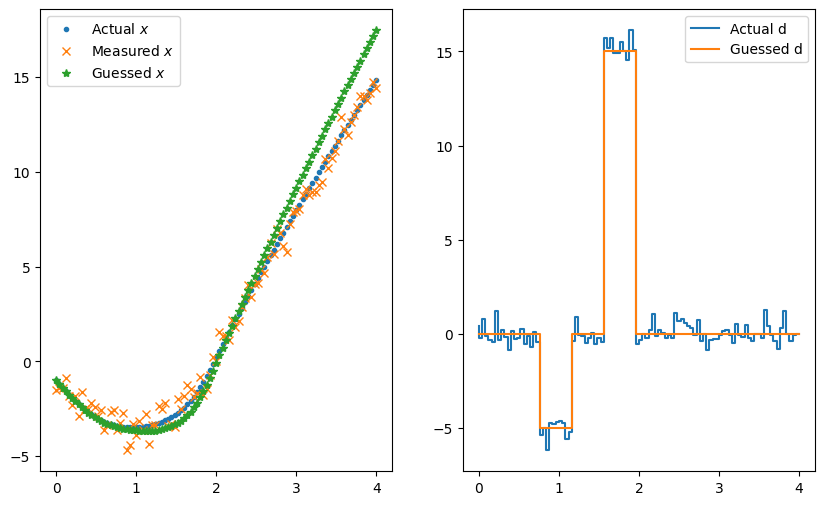

In [44]:
# Actual initial conditions that we will try to found
p_actual = [0.15, 3.0, 1.4]
# Add random noise to the disturbances
rng = np.random.default_rng(seed=42)
print(rng)
u_actual = u_traj + 0.5 * np.random.normal(size = u_traj.shape)
# Simulate to get values for x
x_actual = optsim(x0 = x0, p = p_actual, u = u_actual)['xf'][x.index('x'), :].full().flatten()
# Add some random noise to get measurements
x_meas = x_actual + 0.6 * np.random.normal(size = x_actual.shape)
x_meas
# Get x corresponding to initial guess
x_guess = pertres[0]['xf'][x.index('x'), :].full().flatten()
# Plot
fig, (ax_x, ax_u) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,6))
ax_x.plot(tgrid, x_actual, '.', label = 'Actual $x$')
ax_x.plot(tgrid, x_meas, 'x', label = 'Measured $x$')
ax_x.plot(tgrid, x_guess, '*', label = 'Guessed $x$')
ax_x.legend()
uname = dae.u()[0]
ax_u.step(tgrid, u_actual, label = f'Actual {uname}')
ax_u.step(tgrid, u_traj, label = f'Guessed {uname}')
ax_u.legend()


In [45]:
# Single shooting
w = ca.MX.sym('w', len(p0))  # the unknown parameters
w0 = np.array(p0)
lbw = w0 - 2
ubw = w0 + 2

In [46]:
# Initial x, symbolic
X0 = ca.MX(x0)

In [47]:
# Call the simulator with expressions for x0
symsim = optsim(x0 = X0, u = u_traj, p = w)
# Get expressions for x
x_sym = symsim['xf'][x.index('x'), :]
# Least squares objective
f = ca.sumsqr(x_sym - ca.DM(x_meas).T)

In [48]:
# Evaluate objective
ffun = ca.Function('f', [w], [f], ['w'], ['f'])
f_guess = ffun(w0)
# Also evaluate for actual solution
f_actual = ffun(p_actual)
# Print result
print(f'f_guess = {f_guess}, f_actual = {f_actual}')


f_guess = 155.68, f_actual = 25.5163


In [49]:
# Form NLP
nlp = dict(x = w, f = f)

In [50]:
# Formulate single shooting problem
solver = ca.nlpsol('solver', 'ipopt', nlp, {'ipopt.hessian_approximation': 'limited-memory'})
optres = solver(x0 = w0)

CasADi - 2024-11-18 11:08:19 WARNING("Event support is experimental") [.../casadi/core/integrator.cpp:761]
CasADi - 2024-11-18 11:08:19 WARNING("Event support is experimental") [.../casadi/core/integrator.cpp:761]



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

rhs failed: KeyboardInterrupt
At t = 1.68023, the right-hand side routine failed in an unrecoverable manner.
Function fsens64_sim (0x4b56860)
Input 0 (x0): 
[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
 [-5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
 [-1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Input 1 (z0): 0x65
Input 2 (p): 
[[0.0954517, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
 [3.6

In [ ]:
optres

{'f': DM(28.2832),
 'g': DM(0x1),
 'lam_g': DM(0x1),
 'lam_p': DM(0x0),
 'lam_x': DM([0, 0, 0]),
 'x': DM([0.106297, 3.38001, 1.57211])}

In [ ]:
p_optimized = optres['x'].full().flatten()
p_optimized

array([0.10629688, 3.38000746, 1.57211312])

In [ ]:
# Simulate to get values for x
x_optimized = optsim(x0 = x0, p = p_optimized, u = u_traj)['xf'][x.index('x'), :].full().flatten()

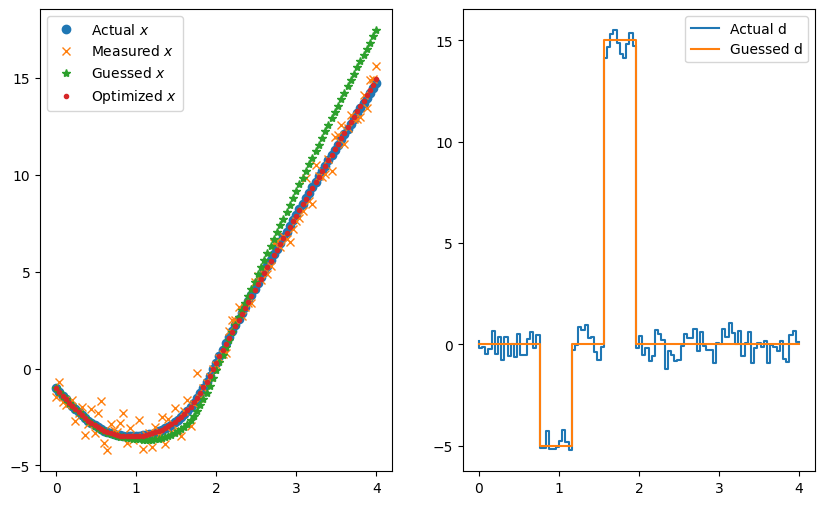

In [ ]:
# Plot the results
fig, (ax_x, ax_u) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,6))
ax_x.plot(tgrid, x_actual, 'o', label = 'Actual $x$')
ax_x.plot(tgrid, x_meas, 'x', label = 'Measured $x$')
ax_x.plot(tgrid, x_guess, '*', label = 'Guessed $x$')
ax_x.plot(tgrid, x_optimized, '.', label = 'Optimized $x$')
ax_x.legend()
uname = dae.u()[0]
ax_u.step(tgrid, u_actual, label = f'Actual {uname}')
ax_u.step(tgrid, u_traj, label = f'Guessed {uname}')
ax_u.legend()


In [ ]:
p0

[0.1, 2.0, 1.0]